In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [21]:
def FFT2D(image, magnitude_filename="magnitude_spectrum.png", phase_filename="phase_spectrum.png"):
    """
    Perform a 2D Fast Fourier Transform (FFT) on the input image and save magnitude and phase spectra as images.

    Parameters:
    - image: List, string, or numpy array representing the image. If a string, it's the path to the image file.
    - magnitude_filename: Filename for saving the magnitude spectrum image.
    - phase_filename: Filename for saving the phase spectrum image.
    """

    # Convert input image to numpy array
    if isinstance(image, list):
        # Convert list to a numpy array
        img_arr = np.array(image)
        # If the list is 1D, assume it's a flattened square image
        if len(img_arr.shape) == 1:
            side_length = int(np.sqrt(len(img_arr)))  # Calculate the side length of the square
            img_arr = img_arr.reshape((side_length, side_length))  # Reshape into 2D array
        # Check if the reshaped array is not 2D
        elif len(img_arr.shape) != 2:
            raise ValueError("List of pixel values must represent a 2D image array")

    elif isinstance(image, str):
        # Load the image from the file path
        img = Image.open(image).convert('L')  # Convert image to grayscale
        img_arr = np.array(img)  # Convert image to numpy array

    elif isinstance(image, np.ndarray):
        # Ensure the numpy array is 2D
        if len(image.shape) != 2:
            raise ValueError("Numpy array must be a 2D array representing a grayscale image")
        img_arr = image  # Use the provided numpy array as the image array

    else:
        raise TypeError("Input must be a list of pixel values, a single image path, or a numpy array")

    def FFT(x):
        """
        Compute the Fast Fourier Transform of a 1D array using the Cooley-Tukey algorithm.
        """
        N = len(x)  # Length of the input array
        # Compute the next power of 2 greater than or equal to N
        N_padded = 2**int(np.ceil(np.log2(N)))
        
        # Zero-padding to the next power of 2 if necessary
        if N != N_padded:
            x = np.pad(x, (0, N_padded - N), mode='constant')  # Pad with zeros
            N = N_padded  # Update N to the new size

        # Base case: FFT of a single element
        if N == 1:
            return x
        else:
            # Recursively compute FFT of even and odd indexed elements
            X_even = FFT(x[::2])
            X_odd = FFT(x[1::2])
            # Compute the FFT factors
            factor = np.exp(-2j * np.pi * np.arange(N) / N)

            # Combine results from even and odd parts
            X = np.zeros(N, dtype=complex)
            X[:N//2] = X_even + factor[:N//2] * X_odd
            X[N//2:] = X_even + factor[N//2:] * X_odd

            return X
    
    def fftshift(spectrum):
        """
        Shift zero-frequency components to the center of the spectrum.
        """
        rows, cols = spectrum.shape  # Get dimensions of the spectrum
        mid_row, mid_col = rows // 2, cols // 2  # Find the midpoint

        # Create an empty array for the shifted spectrum
        shifted_spectrum = np.zeros_like(spectrum, dtype=spectrum.dtype)
        # Place quadrants into the appropriate positions
        shifted_spectrum[:mid_row, :mid_col] = spectrum[mid_row:, mid_col:]
        shifted_spectrum[mid_row:, mid_col:] = spectrum[:mid_row, :mid_col]
        shifted_spectrum[:mid_row, mid_col:] = spectrum[mid_row:, :mid_col]
        shifted_spectrum[mid_row:, :mid_col] = spectrum[:mid_row, mid_col:]

        return shifted_spectrum
    
    def plot(magnitude_spectrum, phase_spectrum):
        """
        Plot the magnitude and phase spectra.
        """
        plt.figure(figsize=(12, 6))  # Create a figure with specified size

        # Plot magnitude spectrum
        plt.subplot(1, 2, 1)
        plt.title("Magnitude Spectrum")
        plt.imshow(np.log(1 + magnitude_spectrum))  # Display log of magnitude spectrum for better visibility
        plt.colorbar()  # Add a color bar

        # Plot phase spectrum
        plt.subplot(1, 2, 2)
        plt.title("Phase Spectrum")
        plt.imshow(phase_spectrum)  # Display phase spectrum
        plt.colorbar()  # Add a color bar

        plt.show()  # Show the plots
    
    def save_spectra_images(magnitude_spectrum, phase_spectrum, output_dir, mag_filename, phase_filename):
        """
        Save the magnitude and phase spectra as images.
        """
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save magnitude spectrum image
        magnitude_image_path = os.path.join(output_dir, mag_filename)
        plt.imsave(magnitude_image_path, np.log(1 + magnitude_spectrum))  # Save the log of magnitude spectrum

        # Save phase spectrum image
        phase_image_path = os.path.join(output_dir, phase_filename)
        plt.imsave(phase_image_path, phase_spectrum)  # Save the phase spectrum

    # Compute 2D FFT by applying FFT to rows and then columns
    fft_rows = np.array([FFT(row) for row in img_arr])  # FFT on each row
    fft_2d = np.array([FFT(col) for col in fft_rows.T]).T  # FFT on each column of the result

    # Compute magnitude and phase spectra
    magnitude_spectrum = np.abs(fft_2d)  # Magnitude of the FFT result
    phase_spectrum = np.angle(fft_2d)  # Phase of the FFT result

    # Shift zero-frequency components to the center of the spectrum
    shifted_magnitude_spectrum = fftshift(magnitude_spectrum)
    shifted_phase_spectrum = fftshift(phase_spectrum)

    # Plot and save spectra images
    plot(shifted_magnitude_spectrum, shifted_phase_spectrum)
    save_spectra_images(shifted_magnitude_spectrum, shifted_phase_spectrum, "output images", magnitude_filename, phase_filename)

    return fft_2d  # Return the 2D FFT result

In [22]:
def inv_FFT2D(fft_image, output_filename="reconstructed_image.png"):
    """
    Perform a 2D Inverse Fast Fourier Transform (IFFT) on the input FFT image and save the reconstructed image.

    Parameters:
    - fft_image: 2D numpy array of the FFT result to be transformed back into the spatial domain.
    - output_filename: Filename for saving the reconstructed image.
    """
    
    def inverse_FFT(X):
        """
        Compute the Inverse Fast Fourier Transform of a 1D array using the Cooley-Tukey algorithm.
        """
        N = len(X)  # Length of the input array
        
        # Base case: IFFT of a single element
        if N <= 1:
            return X
        else:
            # Recursively compute IFFT of even and odd indexed elements
            X_even = inverse_FFT(X[::2])
            X_odd = inverse_FFT(X[1::2])
            # Compute the IFFT factors
            factor = np.exp(2j * np.pi * np.arange(N) / N)
            # Combine results from even and odd parts
            return (np.concatenate([X_even + factor[:N//2] * X_odd, X_even + factor[N//2:] * X_odd])) / N
    
    # Compute the IFFT for each row of the 2D FFT image
    ifft_rows = np.array([inverse_FFT(row) for row in fft_image])
    
    # Compute the IFFT for each column of the result
    ifft_2d = np.array([inverse_FFT(col) for col in ifft_rows.T]).T

    # Take the real part of the IFFT result (imaginary part should be negligible)
    reconstructed_image = np.real(ifft_2d)
    
    # Normalize the image to the range [0, 255] for display
    # Scale the image to the range [0, 255]
    reconstructed_image = 255 * (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image))
    
    # Convert the image array to unsigned 8-bit integer type
    reconstructed_image = reconstructed_image.astype(np.uint8)

    # Create the output directory if it does not exist
    output_dir = "output images"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the reconstructed image to the specified file path
    output_path = os.path.join(output_dir, output_filename)
    Image.fromarray(reconstructed_image).save(output_path)

    return ifft_2d  # Return the 2D IFFT result

In [23]:
def process_image(image_path, output_filename="dip_processed.tif"):
    """
    Process an image using a sequence of operations involving FFT and its conjugate according to the given operations.

    Parameters:
    - image_path: Path to the input image file.
    - output_filename: Filename for saving the processed image.
    """
    # Open and convert the image to grayscale
    img = Image.open(image_path).convert('L')
    img_arr = np.array(img)  # Convert image to numpy array

    # Get image dimensions
    x, y = img_arr.shape

    # Initialize a new array for processing
    new = np.zeros((x, y))

    # Apply a checkerboard pattern to the image array
    for i in range(x):
        for j in range(y):
            new[i][j] = img_arr[i][j] * (-1)**(i + j)

    # Perform 2D FFT on the processed image
    fft = FFT2D(new)
    
    # Compute the complex conjugate of the FFT result
    fft_conj = np.conj(fft)
    
    # Perform 2D Inverse FFT on the conjugated FFT result
    inv = inv_FFT2D(fft_conj)
    
    # Extract the real part of the inverse FFT result
    real = np.real(inv)

    # Initialize a final array for the processed image
    x2, y2 = real.shape
    final = np.zeros((x2, y2))

    # Apply the checkerboard pattern again to the real part
    for i in range(x2):
        for j in range(y2):
            final[i][j] = real[i][j] * (-1)**(i + j)

    # Normalize the final image to the range [0, 255]
    final_normalized = 255 * (final - np.min(final)) / (np.max(final) - np.min(final))
    final_normalized = final_normalized.astype(np.uint8)  # Convert to unsigned 8-bit integer type

    # Create the output directory if it does not exist
    output_dir = "output images"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the processed image to the specified file path
    output_path = os.path.join(output_dir, output_filename)
    Image.fromarray(final_normalized).save(output_path)

    # Display the processed image using matplotlib
    plt.imshow(final_normalized, cmap='gray')
    plt.colorbar()  # Add a color bar to the plot
    plt.title('Resultant Image')  # Set the title of the plot
    plt.show()  # Show the plot

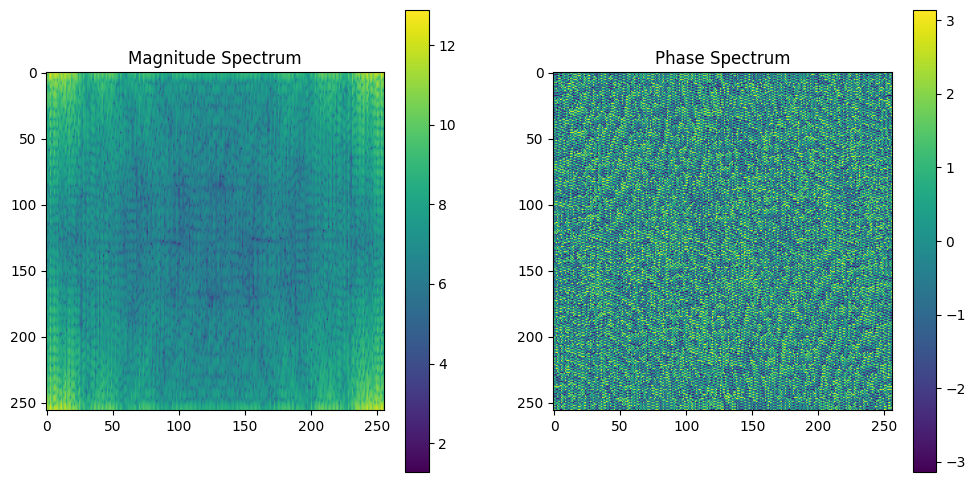

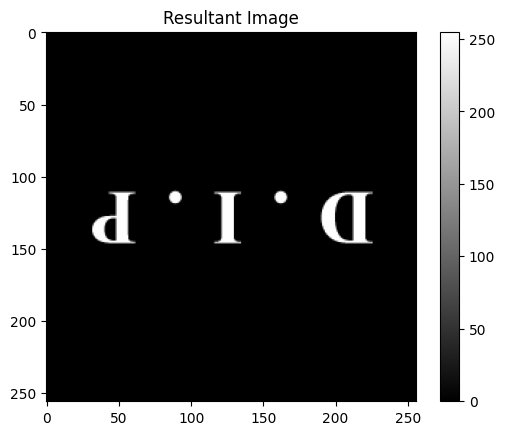

In [24]:
process_image('images/dip.tif')

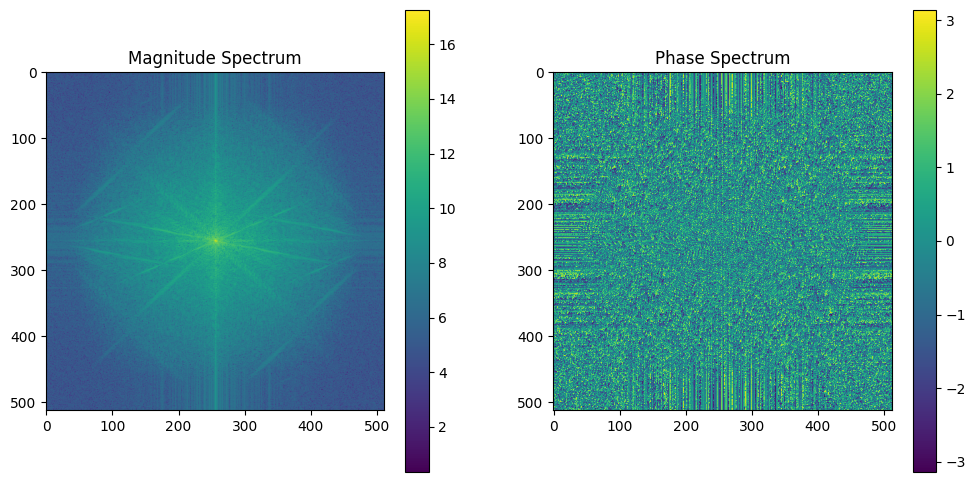

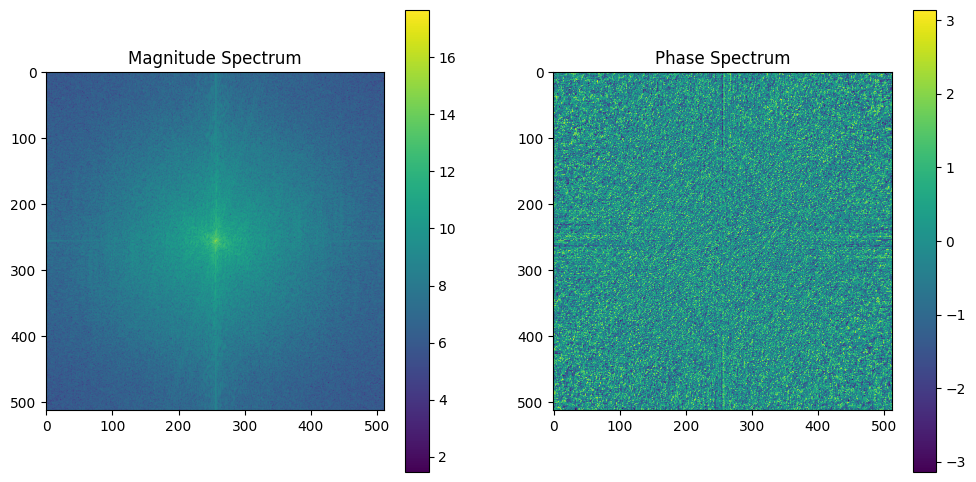

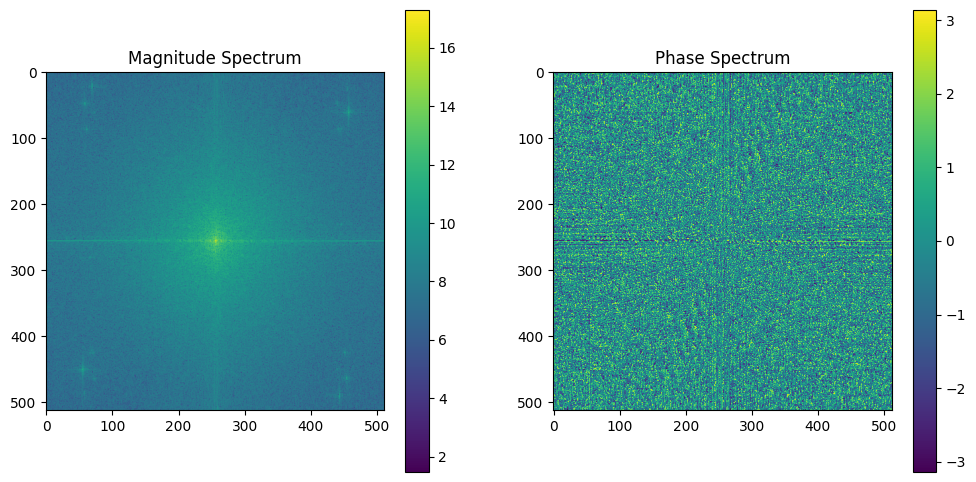

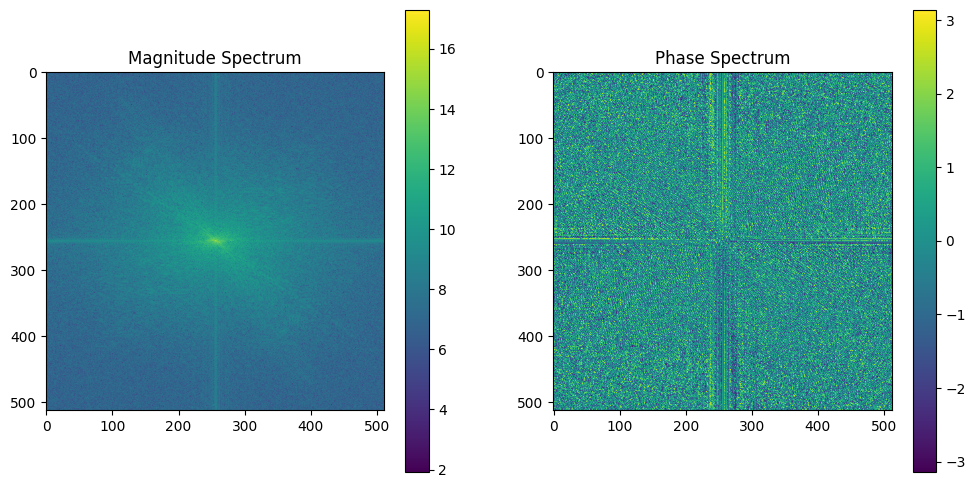

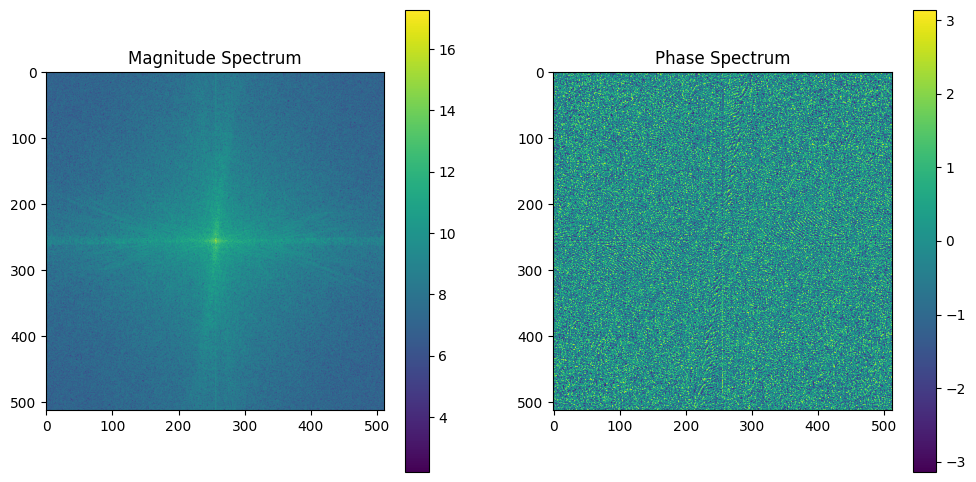

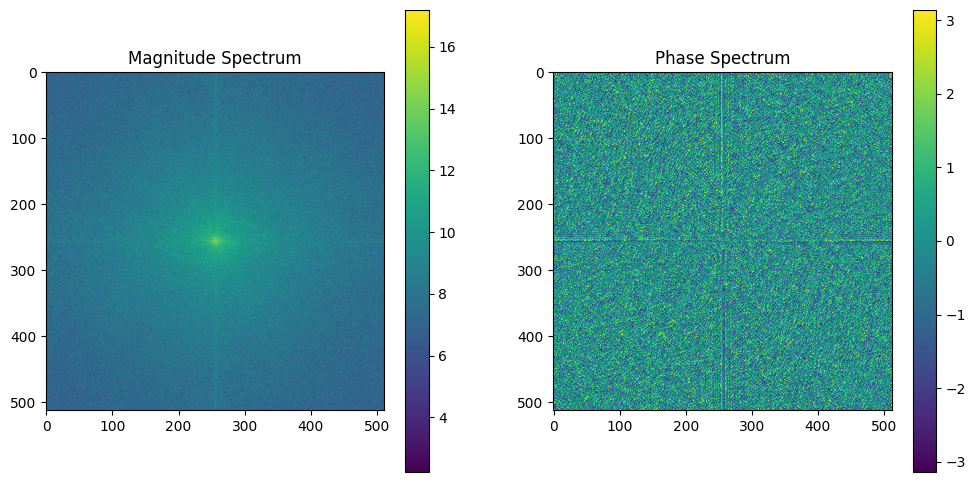

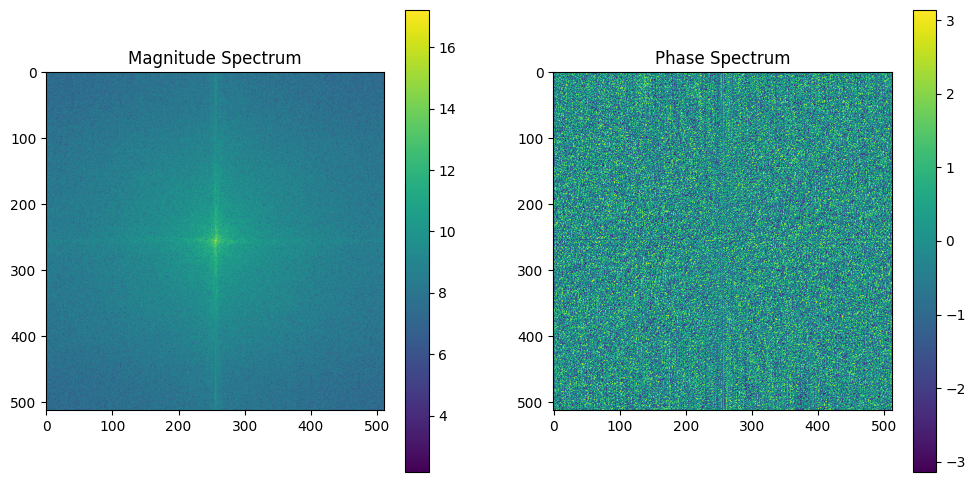

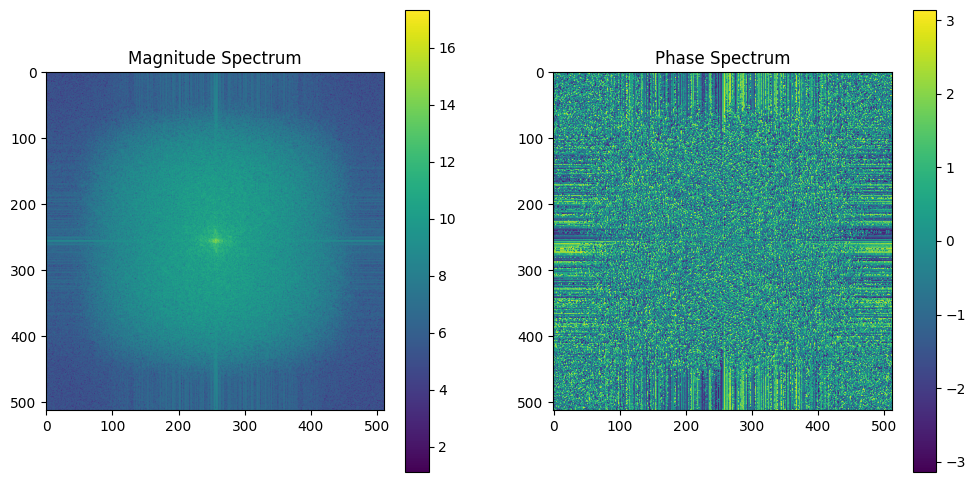

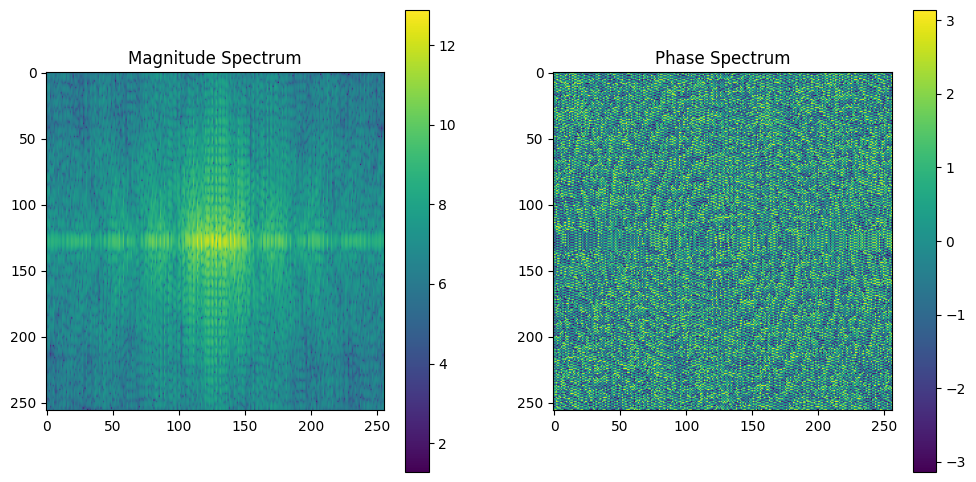

In [25]:
cam = FFT2D("images/cameraman.jpg", "cameraman_magnitude_spectrum.jpg", "cameraman_phase_spectrum.jpg")
jet = FFT2D("images/jetplane.jpg", "jetplane_magnitude_spectrum.jpg", "jetplane_phase_spectrum.jpg")
lake = FFT2D("images/lake.jpg", "lake_magnitude_spectrum.jpg", "lake_phase_spectrum.jpg")
lena = FFT2D("images/lena_gray_512.jpg", "lena_magnitude_spectrum.jpg", "lena_phase_spectrum.jpg")
living = FFT2D("images/livingroom.jpg", "livingroom_magnitude_spectrum.jpg", "livingroom_phase_spectrum.jpg")
pirate = FFT2D("images/pirate.jpg", "pirate_magnitude_spectrum.jpg", "pirate_phase_spectrum.jpg")
walk = FFT2D("images/walkbridge.jpg", "walkbridge_magnitude_spectrum.jpg", "walkbridge_phase_spectrum.jpg")
mandril = FFT2D("images/mandril_gray.jpg", "mandril_magnitude_spectrum.jpg", "mandril_phase_spectrum.jpg")
dip = FFT2D("images/dip.tif", "dip_magnitude_spectrum.jpg", "dip_phase_spectrum.jpg")

In [26]:
c = inv_FFT2D(cam, "cameraman_reconstrcuted.jpg")
j = inv_FFT2D(jet, "jetplane_reconstrcuted.jpg")
l = inv_FFT2D(lake, "lake_reconstrcuted.jpg")
le = inv_FFT2D(lena, "lena_reconstrcuted.jpg")
li = inv_FFT2D(living, "livingroom_reconstrcuted.jpg")
p = inv_FFT2D(pirate, "pirate_reconstrcuted.jpg")
w = inv_FFT2D(walk, "walkbridge_reconstrcuted.jpg")
m = inv_FFT2D(mandril, "mandril_reconstrcuted.jpg")
d = inv_FFT2D(dip, "dip_reconstrcuted.tif")